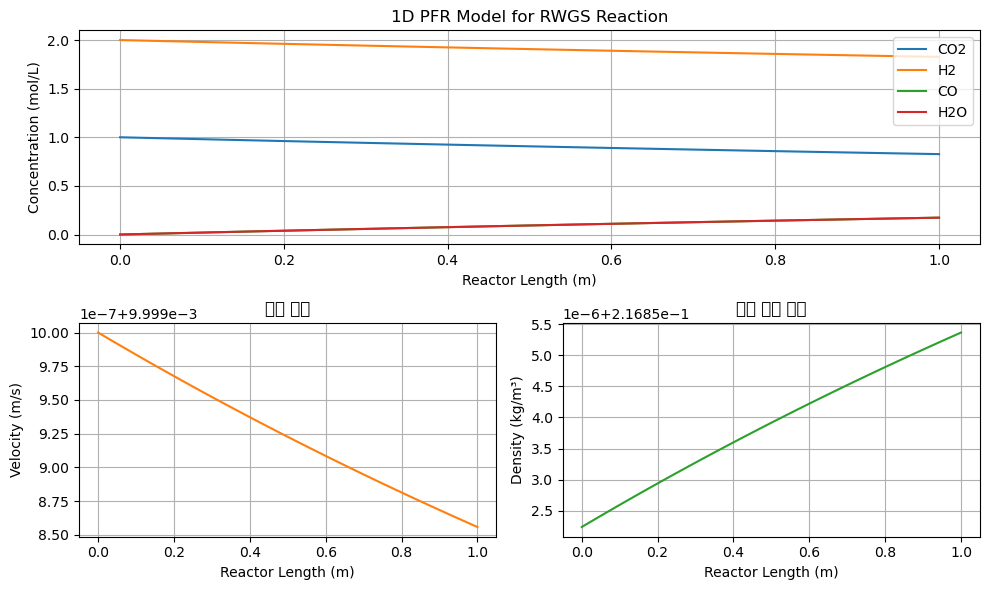

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1D 반응기 모델 (Plug Flow Reactor, PFR) 예시
# CO2 + H2 <-> CO + H2O (RWGS 반응)

# 상수 정의
R = 8.314  # J/(mol*K)
T = 900    # K (예시)
P = 101325 # Pa

# 반응 속도 상수 (예시값)
k_f = 1e-3  # forward rate constant, mol/(L*s)
k_r = 5e-4  # reverse rate constant, mol/(L*s)

# 반응기 길이 및 단면적
L = 1.0     # m
A = 0.01    # m^2
u0 = 0.01   # m/s (초기 유속)

# 초기 농도 (mol/L)
C0_CO2 = 1.0
C0_H2 = 2.0
C0_CO = 0.0
C0_H2O = 0.0

# 초기 전체 몰수 (mol/L 단위, 전체 부피는 나중에 계산)
C0_total = C0_CO2 + C0_H2 + C0_CO + C0_H2O

def pfr_ode(z, y):
    # y: [CO2, H2, CO, H2O, u, rho]
    CO2, H2, CO, H2O, u, rho = y
    # 반응 속도식
    r = k_f * CO2 * H2 - k_r * CO * H2O

    # 전체 농도 (mol/L)
    C_total = CO2 + H2 + CO + H2O

    # 이상기체 상태방정식으로 밀도 계산 (kg/m^3)
    # 각 성분의 분자량 (g/mol)
    MW_CO2 = 44.01
    MW_H2 = 2.016
    MW_CO = 28.01
    MW_H2O = 18.02
    # 평균 분자량 (g/mol)
    MW_avg = (CO2*MW_CO2 + H2*MW_H2 + CO*MW_CO + H2O*MW_H2O) / (C_total + 1e-12)
    # 밀도 (kg/m^3) = (P * MW_avg) / (R * T * 1000)
    # (1000은 g->kg, L->m^3 변환)
    rho_new = (P * MW_avg) / (R * T * 1000)

    # 유속 변화 (질량 보존: u * rho = 일정)
    # u0 * rho0 = u * rho_new  =>  u = u0 * rho0 / rho_new
    # 단, dz에 따라 변화하므로, 미분식으로 표현
    # du/dz = -u * (1/rho) * drho/dz
    # drho/dz 계산 필요

    # 각 성분의 미분
    dCO2_dz = -r / u
    dH2_dz = -r / u
    dCO_dz = r / u
    dH2O_dz = r / u

    # drho/dz 계산
    # drho/dz = (P/(R*T*1000)) * d(MW_avg)/dz
    # d(MW_avg)/dz = (sum(MWi * dCi/dz) * C_total - sum(MWi * Ci) * dC_total/dz) / (C_total^2)
    dC_total_dz = dCO2_dz + dH2_dz + dCO_dz + dH2O_dz
    num = (MW_CO2*dCO2_dz + MW_H2*dH2_dz + MW_CO*dCO_dz + MW_H2O*dH2O_dz) * C_total \
        - (CO2*MW_CO2 + H2*MW_H2 + CO*MW_CO + H2O*MW_H2O) * dC_total_dz
    denom = (C_total + 1e-12)**2
    dMW_avg_dz = num / denom
    drho_dz = (P/(R*T*1000)) * dMW_avg_dz

    # du/dz = -u * (1/rho) * drho/dz
    du_dz = -u * (1/(rho+1e-12)) * drho_dz

    return [dCO2_dz, dH2_dz, dCO_dz, dH2O_dz, du_dz, drho_dz]

# z축 (반응기 길이 방향)
z_span = (0, L)
z_eval = np.linspace(0, L, 100)

# 초기 밀도 계산
MW_CO2 = 44.01
MW_H2 = 2.016
MW_CO = 28.01
MW_H2O = 18.02
MW_avg0 = (C0_CO2*MW_CO2 + C0_H2*MW_H2 + C0_CO*MW_CO + C0_H2O*MW_H2O) / (C0_CO2 + C0_H2 + C0_CO + C0_H2O)
rho0 = (P * MW_avg0) / (R * T * 1000)  # kg/m^3

# 초기 조건
C0 = [C0_CO2, C0_H2, C0_CO, C0_H2O, u0, rho0]

# ODE 풀기
sol = solve_ivp(pfr_ode, z_span, C0, t_eval=z_eval)

# 결과 플롯
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(sol.t, sol.y[0], label='CO2')
plt.plot(sol.t, sol.y[1], label='H2')
plt.plot(sol.t, sol.y[2], label='CO')
plt.plot(sol.t, sol.y[3], label='H2O')
plt.xlabel('Reactor Length (m)')
plt.ylabel('Concentration (mol/L)')
plt.title('1D PFR Model for RWGS Reaction')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(sol.t, sol.y[4], label='u (m/s)', color='tab:orange')
plt.xlabel('Reactor Length (m)')
plt.ylabel('Velocity (m/s)')
plt.title('유속 변화')
plt.grid()

plt.subplot(2,2,4)
plt.plot(sol.t, sol.y[5], label='Density (kg/m^3)', color='tab:green')
plt.xlabel('Reactor Length (m)')
plt.ylabel('Density (kg/m³)')
plt.title('기체 밀도 변화')
plt.grid()

plt.tight_layout()
plt.show()
